In [7]:
import os

import numpy as np
import matplotlib.pyplot as plt

import json

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import nn

from datasets import DatasetDIDC
from unet_advanced import UNetAdvanced as UNetGan
from unet_advanced import UNetAdvanced

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"  

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Selected device: {device}")
print(f'Num available GPUs: ', torch.cuda.device_count())


p = torch.cuda.get_device_properties()
print(f"Device: {p.name} (Memory: {p.total_memory / 1e9:.2f} GB)")

Selected device: cuda
Num available GPUs:  1
Device: NVIDIA TITAN RTX (Memory: 25.19 GB)


In [3]:
DATA_DIR = "./New_dictionary"

## GAN basic train 0
with best hyperparams from the other dataset (shown below)

Target data are noisy --> more preprocessing is needed
image cut with respect to the bkg is tricking the model --> crop? model with multi level discriminator?

Should've trained longer

In [4]:
dir_name = 'experiments/DIDC/20260212_1556_MT_DIDC_basic_gan'

Best train_D_loss: 0.0178
Best train_G_loss: 8.0031
Best train_CE_loss: 0.4540
Best val_G_loss: 0.8859
Best val_CE_loss: 0.7197
Best val_Dice_loss: 0.6222


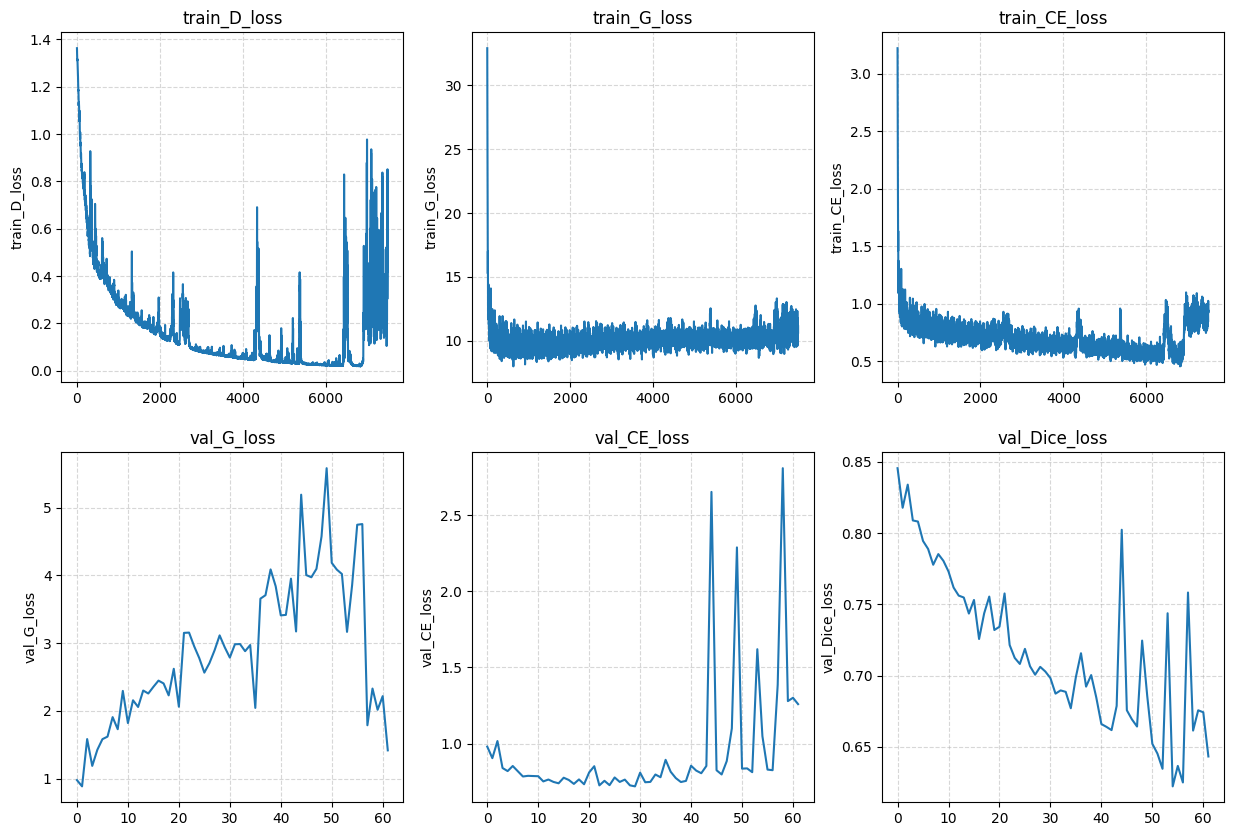

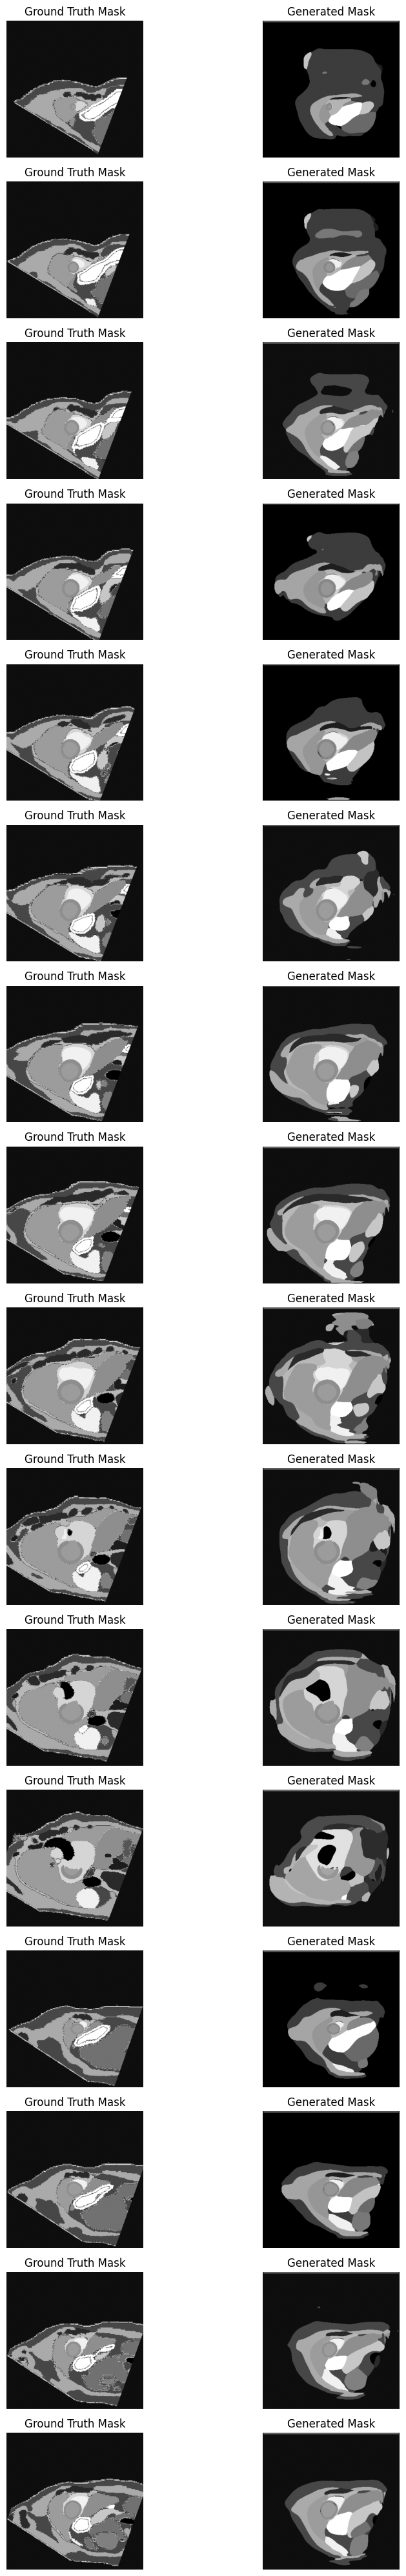

{'num_steps': 7500,
 'n_discr_steps': 1,
 'lambda_ce': 10.0,
 'val_check_interval': 120,
 'batch_size': 16,
 'learning_rate_gen': 0.0001,
 'learning_rate_discr': 1e-05,
 'notes': 'Basic GAN training on DIDC data with best hyperparam found in previous exp (lr, lambda and patience = 15)',
 'patience_es': 15,
 'delta_es': 0.01,
 'dropout_gen': 0.3,
 'num_gpus': 2,
 'validation_fraction': 0.2,
 'target_size': [384, 384],
 'seed': 187}

In [5]:
if os.path.exists(dir_name):
    if os.path.isfile(dir_name + "/config.json") or os.path.isfile(dir_name + "/metrics_history.json"):
        with open(f"{dir_name}/config.json", "r") as f:
            training_config = json.load(f)

        with open(f"{dir_name}/metrics_history.json", "r") as f:
            metrics_history = json.load(f)
    
    if os.path.isfile(dir_name + "/train_val_split.json"):
        with open(f"{dir_name}/train_val_split.json", "r") as f:
            train_val_split = json.load(f)
    
    if os.path.isfile(dir_name + "/grouping_rules_and_labels.json"):
        with open(f"{dir_name}/grouping_rules_and_labels.json", "r") as f:
            grouping_rules_and_labels = json.load(f)
            grouping_rules = grouping_rules_and_labels['grouping_rules']
            new_labels = grouping_rules_and_labels['new_labels']

val_dataset = DatasetDIDC(DATA_DIR, grouping_rules, new_labels, target_size=training_config['target_size'], rm_black_slices=True, file_list=train_val_split['val_indices'])    
dataloader = DataLoader(val_dataset, batch_size=training_config['batch_size'], shuffle=False)
batch = next(iter(dataloader))

n_input_classes = 4
n_output_classes = len(val_dataset.new_labels)
gen = UNetGan(in_ch=n_input_classes, num_classes=n_output_classes, dropout_p=training_config['dropout_gen']).to(device)

gen = nn.DataParallel(gen)
gen.load_state_dict(torch.load(dir_name+"/best_generator.pth", weights_only=True))
gen.eval()

with torch.no_grad():
    input_label = batch['input_label'].to(device)
    multi_tissue_masks = batch['multiClassMask'].to(device)
    output = gen(input_label)

fig, ax = plt.subplots(2, len(metrics_history)//2, figsize=(15, 10))
ax = ax.flatten()
for i, (metric_name, metric_values) in enumerate(metrics_history.items()):
    if metric_name == 'current_step':
        break
    ax[i].plot(metric_values)
    ax[i].set_title(metric_name)
    ax[i].set_ylabel(metric_name)
    ax[i].grid(linestyle='--', alpha=0.5)

for metric_name, metric_values in metrics_history.items():
    if metric_name == 'current_step':
        continue
    best_value = max(metric_values) if 'loss' not in metric_name else min(metric_values)
    print(f"Best {metric_name}: {best_value:.4f}")

# Plot images
fig, ax = plt.subplots(len(batch['input_label']), 2, figsize=(10, 40))
for i in range(len(batch['input_label'])):
    ax[i, 0].imshow(multi_tissue_masks[i].cpu().numpy(), cmap='gray')
    ax[i, 0].set_title('Ground Truth Mask')
    ax[i, 0].axis('off')

    output_mask = torch.argmax(output[i], dim=0).cpu().numpy()
    ax[i, 1].imshow(output_mask, cmap='gray')
    ax[i, 1].set_title('Generated Mask')
    ax[i, 1].axis('off')

plt.tight_layout()
plt.show()

training_config

## UNet advanced training 0

In [9]:
dir_name = 'experiments/DIDC/20260212_1802_MT_DIDC_UNet'

Best train_loss: 0.5996
Best val_loss: 0.7170
Best train_dice_score: 0.7995
Best val_dice_score: 0.9362
Best learning_rate: 0.0010


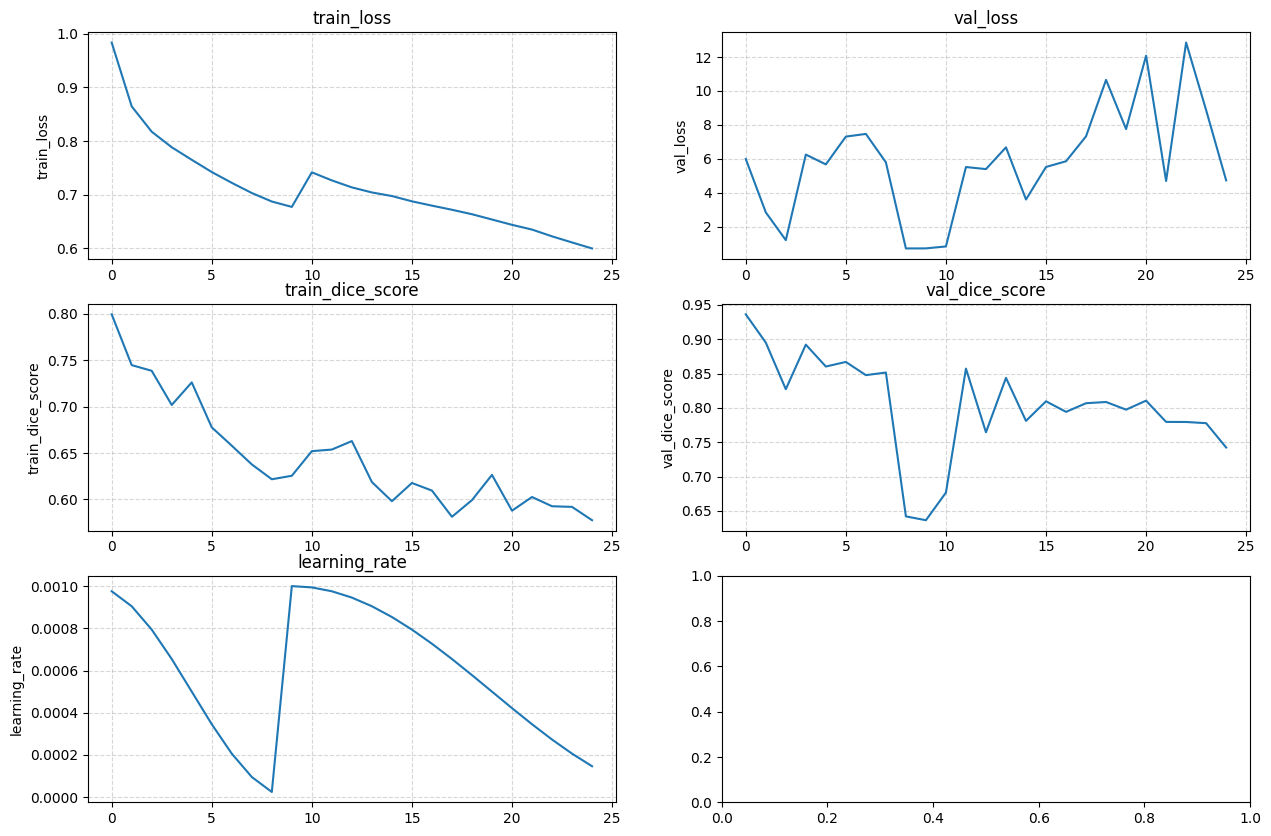

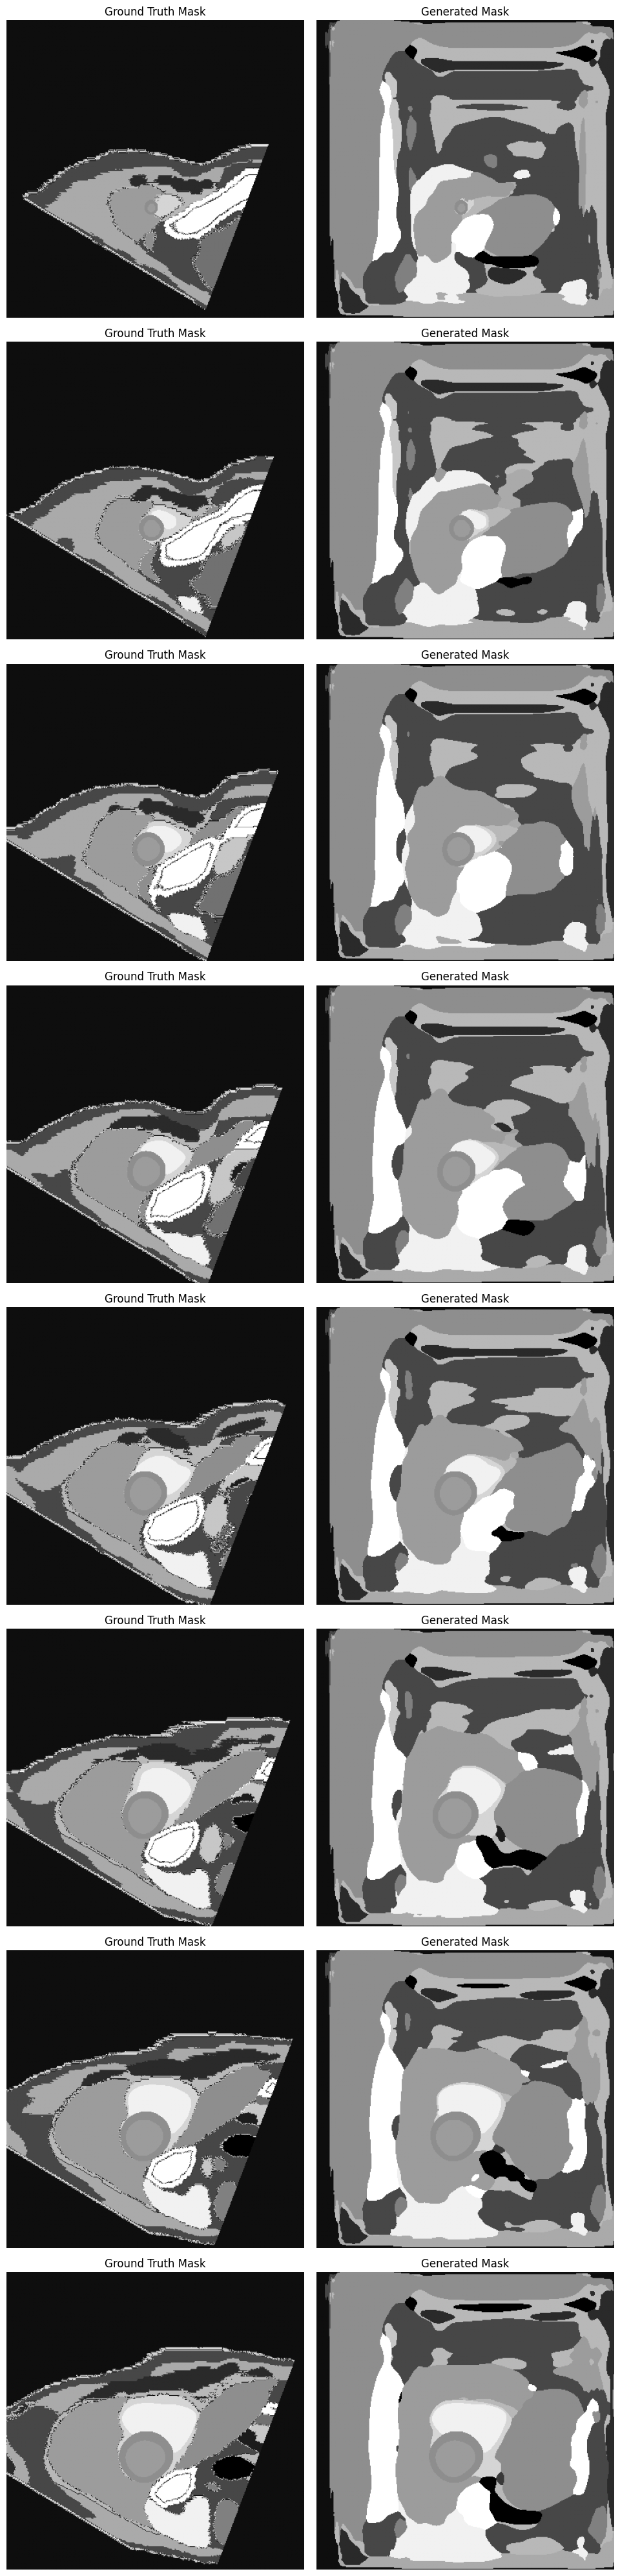

{'seed': 187,
 'val_fraction': 0.2,
 'target_size': [384, 384],
 'run_name': 'MT_DIDC_UNet',
 'notes': 'Basic UNet training on DIDC data',
 'parallel': True,
 'batch_size': 8,
 'learning_rate': 0.001,
 'epochs': 150,
 'patience_es': 15,
 'delta_es': 0.005}

In [12]:
if os.path.exists(dir_name):
    if os.path.isfile(dir_name + "/config.json") or os.path.isfile(dir_name + "/metrics_history.json"):
        with open(f"{dir_name}/config.json", "r") as f:
            training_config = json.load(f)

        with open(f"{dir_name}/metric_history.json", "r") as f:
            metrics_history = json.load(f)
    
    if os.path.isfile(dir_name + "/train_val_split.json"):
        with open(f"{dir_name}/train_val_split.json", "r") as f:
            train_val_split = json.load(f)
    
    if os.path.isfile(dir_name + "/grouping_rules_and_labels.json"):
        with open(f"{dir_name}/grouping_rules_and_labels.json", "r") as f:
            grouping_rules_and_labels = json.load(f)
            grouping_rules = grouping_rules_and_labels['grouping_rules']
            new_labels = grouping_rules_and_labels['new_labels']

val_dataset = DatasetDIDC(DATA_DIR, grouping_rules, new_labels, target_size=training_config['target_size'], rm_black_slices=True, file_list=train_val_split['val_indices'])    
dataloader = DataLoader(val_dataset, batch_size=training_config['batch_size'], shuffle=False)
batch = next(iter(dataloader))

n_input_classes = 4
n_output_classes = len(val_dataset.new_labels)
model = UNetAdvanced(in_ch=n_input_classes, num_classes=n_output_classes).to(device) # no dropout for UNet

model = nn.DataParallel(model)
model.load_state_dict(torch.load(dir_name+"/model_final.pth", weights_only=True))
model.eval()

with torch.no_grad():
    input_label = batch['input_label'].to(device)
    multi_tissue_masks = batch['multiClassMask'].to(device)
    output = model(input_label)

fig, ax = plt.subplots(3, len(metrics_history)//2, figsize=(15, 10))
ax = ax.flatten()
for i, (metric_name, metric_values) in enumerate(metrics_history.items()):
    if metric_name == 'current_step':
        break
    ax[i].plot(metric_values)
    ax[i].set_title(metric_name)
    ax[i].set_ylabel(metric_name)
    ax[i].grid(linestyle='--', alpha=0.5)

for metric_name, metric_values in metrics_history.items():
    if metric_name == 'current_step':
        continue
    best_value = max(metric_values) if 'loss' not in metric_name else min(metric_values)
    print(f"Best {metric_name}: {best_value:.4f}")

# Plot images
fig, ax = plt.subplots(len(batch['input_label']), 2, figsize=(10, 40))
for i in range(len(batch['input_label'])):
    ax[i, 0].imshow(multi_tissue_masks[i].cpu().numpy(), cmap='gray')
    ax[i, 0].set_title('Ground Truth Mask')
    ax[i, 0].axis('off')

    output_mask = torch.argmax(output[i], dim=0).cpu().numpy()
    ax[i, 1].imshow(output_mask, cmap='gray')
    ax[i, 1].set_title('Generated Mask')
    ax[i, 1].axis('off')

plt.tight_layout()
plt.show()

training_config